# **Lyrics Generation Base On Melody and Input Seed - RNN ML Model**

Submitters:
Assaf Attias 308214899
Omer Shlomo 204429278 

# **Preparations**
Prepare Program for running

## Download Data Set and install pretty_midi

---

In [ ]:
# download midi files
!gdown --id 1VHTLxkSrCKzQKLPAtiCc4ROYKcGHrOYC
!unzip midi_files.zip -d data
# download train set
!gdown --id 1n4RnpJ6LxE0KrMG2OAe8ozNN-gjGBgv7
# download test set
!gdown --id 1EOFrTYA-GSeq76EnmW-4eN40fcSat5nw
# download simple model
!gdown --id 1JkyWkLuZosgKjf9-VrJzbqh-pzuInh2b
!unzip simple_model.zip
# download complex model
!gdown --id 11Gj9-fdQl96yOWyHVG8wDlXzTpkiz7eB
!unzip complex_model.zip

Downloading...
From: https://drive.google.com/uc?id=1VHTLxkSrCKzQKLPAtiCc4ROYKcGHrOYC
To: /content/midi_files.zip
6.60MB [00:00, 104MB/s]
Archive:  midi_files.zip
replace data/midi_files/1910_Fruitgum_Company_-_Simon_Says.mid? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# !pip install pretty_midi

## Imports & Constants

---

### imports

In [9]:
import csv, re, os, pretty_midi, pickle
import time

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import json

from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Input, Embedding, dot, Activation, concatenate, Flatten, Bidirectional, Concatenate, MultiHeadAttention, Average
from keras import backend as K
from keras.layers import LSTM
from keras.callbacks import EarlyStopping

from nltk.tokenize import RegexpTokenizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.optimizers import Adam
from keras.callbacks import TensorBoard
import datetime

from IPython.display import Image
from keras.utils import plot_model

from gensim.models import KeyedVectors
import gensim.downloader as word2vec_loader

### constants

In [10]:
# paths
lyrics_test_path = "lyrics_test_set.csv"
lyrics_train_path = "lyrics_train_set.csv"

midi_folder_path = os.path.join("data","midi_files")
train_folder_path = os.path.join("data","train")
test_folder_path = os.path.join("data","test")
temp_folder_path = os.path.join("data","temp")

if not os.path.exists(temp_folder_path):
  os.mkdir(temp_folder_path)

simple_model_path = "simple_model"
complex_model_path = "complex_model"

midi_f_start_name = "song_midi_"
seq_f_start_name = "song_seq_"

if not os.path.exists(train_folder_path):
  os.mkdir(train_folder_path)
  os.mkdir(os.path.join(train_folder_path,"simple"))
  os.mkdir(os.path.join(train_folder_path,"complex"))
if not os.path.exists(test_folder_path):
  os.mkdir(test_folder_path)
  os.mkdir(os.path.join(test_folder_path,"simple"))
  os.mkdir(os.path.join(test_folder_path,"complex"))

tensorboard_logs_folder_path = os.path.join("logs","fit")

# tokenize and array positions
AUTHOR = 0
SONG_NAME = 1
LYRICS = 2
TOKENS = 3
# special tokens
SENTENCE_DELIMITER = 'eos'
LYRICS_END = 'eol'
# base info
MAX_SEQUENCE_LENGTH = 5
EMBEDDING_DIM=300

SEED = 42
np.random.seed(SEED)

# **Load Data**

---
Read and parse the information provided in the assignment

In [11]:
def load_midi_data_index(midi_data_folder):
    """
    read all midi files in a given folder and prepare an index of the midi files

    :param midi_data_folder: path of folder with midi files
    :return: dict of form {(author,song_name) : midi_file_full_path}
    """
    data = {}
    for midi_file_name in os.listdir(midi_data_folder):

        info = re.split('.mid|-', midi_file_name)
        author = info[AUTHOR].replace('_', ' ').lower().strip()
        song_name = info[SONG_NAME].replace('_', ' ').lower().strip()
        data[(author, song_name)] = os.path.join(midi_data_folder, midi_file_name)

    return data

def get_midi_data(midi_index, author, song_name):
    """
    Return a pretty_midi file, replace the path in the index dict and load if needed

    :param midi_index: index created by load_midi_data_index
    :param author: author name of the desired midi file
    :param song_name: song name of the desired midi file
    :return: 
      midi: pretty_midi object if exists, None if not
      loaded: int, 0 if the midi is in the index, 1 if loaded from folder
    """
    load_count = 0
    if (author, song_name) not in midi_index:
        print("did not found midi file for '{}' by '{}'".format(song_name,author))
        return None, load_count

    if isinstance(midi_index[(author, song_name)], str):
        try:
            midi_index[(author, song_name)] = pretty_midi.PrettyMIDI(midi_index[(author, song_name)])
            load_count = 1
        except:
            print("Error When Loaded: '{}' by '{}'. path = {}".format(song_name, author, midi_index[(author, song_name)]))
            return None, load_count

    return midi_index[(author, song_name)], load_count

def csv_to_data(csv_path, midi_index):
    """
    Parse Lyrics csv file and finish loading all needed data from it

    :param csv_path: lyrics csv_file
    :param midi_index: midi index created from load_midi_data_index
    :return: 
      data: list of the lyrics in the csv file
      midi_list: list of pretty_midi coresponding to the data lyrics
    """

    data = []
    midi_list = []

    midi_load_count = 0

    with open(csv_path, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in reader:
            clean_row = [val for val in row if val != '']
            author = clean_row[AUTHOR].strip()

            for song in range(SONG_NAME,len(clean_row),2):
                song_name = clean_row[song].strip()
                lyrics = clean_row[song + 1]

                midi, loaded = get_midi_data(midi_index, author, song_name)

                if midi is None:
                    continue

                midi_load_count += loaded

                midi_list.append(midi)
                data.append([author, song_name, lyrics])

    return data, midi_list, midi_load_count


def load_all_data(lyrics_train_path, lyrics_test_path, midi_folder_path):
    """
    Load all data needed for the program

    :param lyrics_train_path: train csv file path
    :param lyrics_test_path: test csv file path
    :param midi_folder_path: path of folder with midi files
    :return: 
      train_set: train lyrics data
      train_midi_list: train midi data
      test_set: test lyrics data
      test_midi_list: test midi data
      load count: int, how many midi files loaded from data
    """
    midi_index = load_midi_data_index(midi_folder_path)

    train_set, train_midi_list, train_midi_load_count = csv_to_data(lyrics_train_path, midi_index)
    test_set, test_midi_list, test_midi_load_count = csv_to_data(lyrics_test_path, midi_index)

    return train_set, train_midi_list, test_set, test_midi_list, (train_midi_load_count + test_midi_load_count)

In [12]:
start_time = time.time()

train_set, train_midi_list, test_set, test_midi_list, midi_load_count = load_all_data(lyrics_train_path, lyrics_test_path, midi_folder_path)

load_t_stamp = time.time()

len_train = len(train_set)
len_test = len(test_set)
print()
print("Loading Done. midi Song Count: {} [train={}, test={}], loaded at {}sec.".format(len_train+len_test,len_train,len_test,load_t_stamp-start_time))

/usr/local/lib/python3.7/dist-packages/pretty_midi/pretty_midi.py:101: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


did not found midi file for 'act naturally' by 'glen campbell'
Error When Loaded: 'lazarus' by 'david bowie'. path = data/midi_files/David_Bowie_-_Lazarus.mid
Error When Loaded: 'girls' by 'beastie boys'. path = data/midi_files/Beastie_Boys_-_Girls.mid
Error When Loaded: 'movin' out' by 'billy joel'. path = data/midi_files/Billy_Joel_-_Movin'_Out.mid
Error When Loaded: 'pressure' by 'billy joel'. path = data/midi_files/Billy_Joel_-_Pressure.mid
Error When Loaded: 'leader of the band' by 'dan fogelberg'. path = data/midi_files/Dan_Fogelberg_-_Leader_of_the_Band.mid
did not found midi file for 'where my girls at' by 'frankie valli'
did not found midi file for 'all i have to give' by 'ace of base'
Error When Loaded: 'on the down low' by 'brian mcknight'. path = data/midi_files/Brian_McKnight_-_On_The_Down_Low.mid
Error When Loaded: 'tell it like it is' by 'aaron neville'. path = data/midi_files/Aaron_Neville_-_Tell_It_Like_It_Is.mid

Loading Done. midi Song Count: 610 [train=605, test=5],

# **Data Analysis + PreProcess** 
Prepare the data for training and testing

## Lyrics
Analysis and pre-processing of the Text Lyrics

### Data Explore

---


In [13]:
def analyze_row_data(tokens):
    """
    Analyze lyrics data of a given song

    :param tokens: parsed tokens of the lyrics song
    :return: summary information on the lyrics tokens
    """
    tokens_set = set()
    n_tokens = len(tokens)

    n_sentences = 0
    min_token_per_sentence = 10000
    max_token_per_sentence = 0
    sentences_len_counter = 0

    current_sentence_len = 0
    for token in tokens:

        tokens_set.add(token)

        if token == SENTENCE_DELIMITER:

            if current_sentence_len > max_token_per_sentence:
                max_token_per_sentence = current_sentence_len
            if current_sentence_len < min_token_per_sentence:
                min_token_per_sentence = current_sentence_len

            sentences_len_counter += current_sentence_len
            current_sentence_len = 0
            n_sentences += 1
        else:
            current_sentence_len += 1

    return tokens_set, n_tokens, n_sentences, min_token_per_sentence, sentences_len_counter / n_sentences, max_token_per_sentence

### pre proccess
1. Tokenize Lyrics with regex: r'\w+|&+
2. lower case text
3. replace & with >eos< and add >end lyrics< token at the end
4. remove all tokens that are not words (special char and digits)


In [14]:
def preprocess_lyrics_data(data):
    """
    Pre process the given txt lyrics data and extract information about it
    Pre Process:
      1. Tokenize
      2. lower case
      3. remove special chars and digits
      4. replace sentence delimiter and add end of lyrics token at the end

    :param data: lyrics data to process
    :return:
      data: data with updated lyrics after processing
      clean_lyrics_list: list of all the clean text (after preprocess)
      summay_info: analysis info on the lyrics
    """
    tokenizer_reg = RegexpTokenizer(r'\w+|&+')
    clean_lyrics_list = []
    voc = set()

    min_n_sentences = 10000
    max_n_sentences = 0
    avg_n_sentences = 0

    min_n_tokens = 10000
    max_n_tokens = 0
    avg_n_tokens = 0

    min_n_tokens_per_sen = 10000
    max_n_tokens_per_sen = 0
    avg_n_tokens_per_sen = 0

    for i in range(len(data)):

        text_lyrics = data[i][LYRICS]

        clean_lyrics = text_lyrics.lower()

        clean_lyrics = clean_lyrics.replace('&', SENTENCE_DELIMITER)

        clean_lyrics = re.sub(r'\[.*?!\]', '', clean_lyrics)
        clean_lyrics = re.sub("[^\na-z 0-9]", "", clean_lyrics).strip()
        clean_lyrics = re.sub(' +', ' ', clean_lyrics)
        clean_lyrics = clean_lyrics + " " + LYRICS_END

        data[i][LYRICS] = clean_lyrics

        tokens = tokenizer_reg.tokenize(clean_lyrics)

        tokens_set, n_tokens, n_sentences, min_token_per_sentence, avg_token_per_sentence, max_token_per_sentence = analyze_row_data(tokens)

        if n_sentences < min_n_sentences:
            min_n_sentences = n_sentences
        if n_sentences > max_n_sentences:
            max_n_sentences = n_sentences
        avg_n_sentences += n_sentences

        if n_tokens < min_n_tokens:
            min_n_tokens = n_tokens
        if n_tokens > max_n_tokens:
            max_n_tokens = n_tokens
        avg_n_tokens += n_tokens

        if min_token_per_sentence < min_n_tokens_per_sen:
            min_n_tokens_per_sen = min_token_per_sentence
        if max_token_per_sentence > max_n_tokens_per_sen:
            max_n_tokens_per_sen = max_token_per_sentence
        avg_n_tokens_per_sen += avg_token_per_sentence

        voc = voc.union(tokens_set)
        data[i].append(tokens)
        clean_lyrics_list.append(clean_lyrics)

    return data, clean_lyrics_list, voc, ((avg_n_tokens, min_n_tokens,avg_n_tokens / len(data),max_n_tokens),(avg_n_sentences,min_n_sentences,avg_n_sentences / len(data),min_n_sentences),(min_n_tokens_per_sen,avg_n_tokens_per_sen / n_sentences,max_n_tokens_per_sen))

In [15]:
# pre-process
train_set, train_clean_lyrics_list, train_voc, train_analyze_data = preprocess_lyrics_data(train_set)
test_set, test_clean_lyrics_list, test_voc, test_analyze_data = preprocess_lyrics_data(test_set)

# prepare word index (vocabulary)
voc = sorted(list(set.union(train_voc,test_voc)))
clean_lyrics = train_clean_lyrics_list + test_clean_lyrics_list
tokenizer = Tokenizer(num_words=len(voc))
tokenizer.fit_on_texts(clean_lyrics)
word_index = tokenizer.word_index

In [16]:
print("Lyrics Traing Set Information:")
(n_tokens, min_n_token,avg_n_token,max_n_token),(n_sentences, min_n_sentences,avg_n_sentences,max_n_sentences),(min_n_tokens_per_sen,avg_n_tokens_per_sen,max_n_tokens_per_sen) = train_analyze_data
print("found {} sentences in total. per song = [min={},avg={},max={}]".format(n_sentences, min_n_sentences,avg_n_sentences,max_n_sentences))
print("words per sentence info: per song = [min={},avg={},max={}]".format(min_n_tokens_per_sen,avg_n_tokens_per_sen,max_n_tokens_per_sen))
print("found {} words in total. per song = [min={},avg={},max={}], with a vocabulary size of {}".format(n_tokens,min_n_token,avg_n_token,max_n_token, len(voc)))
print()
print("Lyrics Test Set Information:")
(n_tokens, min_n_token,avg_n_token,max_n_token),(n_sentences, min_n_sentences,avg_n_sentences,max_n_sentences),(min_n_tokens_per_sen,avg_n_tokens_per_sen,max_n_tokens_per_sen) = test_analyze_data
print("found {} sentences in total. per song = [min={},avg={},max={}]".format(n_sentences, min_n_sentences,avg_n_sentences,max_n_sentences))
print("words per sentence info: per song = [min={},avg={},max={}]".format(min_n_tokens_per_sen,avg_n_tokens_per_sen,max_n_tokens_per_sen))
print("found {} words in total. per song = [min={},avg={},max={}], with a vocabulary size of {}".format(n_tokens,min_n_token,avg_n_token,max_n_token, len(voc)))

lyrics_preprocess_t_stamp = time.time()
print()
print("lyrics Pre-processed at {} sec.".format(round(lyrics_preprocess_t_stamp-load_t_stamp,3)))

Lyrics Traing Set Information:
found 24086 sentences in total. per song = [min=1,avg=39.811570247933886,max=1]
words per sentence info: per song = [min=0,avg=46.35585454592839,max=292]
found 181577 words in total. per song = [min=15,avg=300.1272727272727,max=1482], with a vocabulary size of 7563

Lyrics Test Set Information:
found 189 sentences in total. per song = [min=16,avg=37.8,max=16]
words per sentence info: per song = [min=2,avg=1.0437831946095917,max=12]
found 1353 words in total. per song = [min=111,avg=270.6,max=448], with a vocabulary size of 7563

lyrics Pre-processed at 0.48 sec.


## Midi
Analysis and pre-processing of the midi files

### Data Explore

In [17]:
def analyze_midi(pm):
    """
    Plot the tempo changes over time, pitch class distribution
    
    :param pm: pretty_midi object to abalyze
    """
    # Plot the tempo changes over time
    # Many MIDI files won't have more than one tempo change event,
    # but this particular file was transcribed to somewhat closely match the original song.
    times, tempo_changes = pm.get_tempo_changes()
    plt.plot(times, tempo_changes, '.')
    plt.xlabel('Time')
    plt.ylabel('Tempo')
    plt.show()
    # Plot a pitch class distribution - sort of a proxy for key
    plt.bar(np.arange(12), pm.get_pitch_class_histogram());
    plt.xticks(np.arange(12), ['C', '', 'D', '', 'E', 'F', '', 'G', '', 'A', '', 'B'])
    plt.xlabel('Note')
    plt.ylabel('Proportion')
    plt.show()

'candle in the wind' by 'elton john' midi file information:


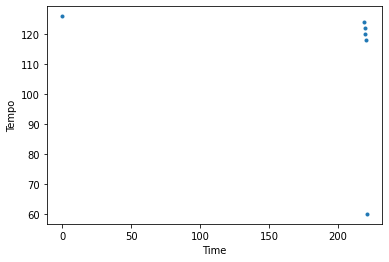

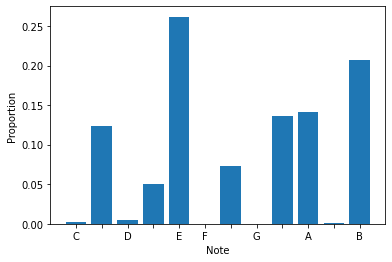

In [18]:
show_midi_ind = 0
print("'{}' by '{}' midi file information:".format(train_set[show_midi_ind][SONG_NAME],train_set[show_midi_ind][AUTHOR]))
analyze_midi(train_midi_list[show_midi_ind])

### pre proccess
pre process pipeline for midi data to extrat features (base on extract function)

In [19]:
def preprocess_midi(midi_list, extract_features_func,type_folder_s_name, save_folder_path):
    """
    Pre process midi object and extract features from it for learning/test base on a given
    extract function and save (cache it) in disk

    :param midi_list: pretty_midi object list to process
    :param extract_features_func: feature extruction function to use on midi object
    :param type_folder_s_name: str, type of feature extruction
    :param save_folder_path: path of folder to cache features for songs
    :return:
      shape of the features extracted from each midi
    """

    midi_features_shape = None

    for song_id, midi in enumerate(midi_list):
        features = extract_features_func(midi)
        midi_features_shape = features.shape

        np.save(os.path.join(save_folder_path,type_folder_s_name,midi_f_start_name) + str(song_id) + '.npy',features)

    return midi_features_shape

#### Approch 1 - Simple Features
Summary of midi data that characterize the song
Hopefully encodes the information
Extract:
1. summary of semitones
2. summary of roll
3. bpm (normalized)

total of 141 features per midi

In [20]:
def extract_midi_features_model_simple(pm):
    """
    Extract features from midi object for simple model, summarized information.
    transitions, semitones, histograms and bpm (tempo) information
    :param pm: pretty_midi object to process
    :return: nd array shape of (309,) with features on the midi
    """
    semitone = pm.get_chroma().sum(axis=1) / pm.get_chroma().sum()  # 12
    piano_roll = pm.get_piano_roll().sum(axis=1) / pm.get_piano_roll().sum()  # 128
    bpm_norm = np.array([pm.estimate_tempo() / 300])  # 1

    features = np.concatenate((semitone, piano_roll, bpm_norm))
    features[np.isnan(features)] = 0

    return features

In [21]:
train_midi_simple_shape = preprocess_midi(train_midi_list,extract_midi_features_model_simple, "simple", train_folder_path)
test_midi_simple_shape = preprocess_midi(test_midi_list,extract_midi_features_model_simple, "simple", test_folder_path)

midi_simple_preprocess_t_stamp = time.time()
print("midi simple Pre-processed at {} sec.".format(round(midi_simple_preprocess_t_stamp-lyrics_preprocess_t_stamp,3)))
print("midi simple shape: {}".format(train_midi_simple_shape))

midi simple Pre-processed at 376.607 sec.
midi simple shape: (141,)


#### Approch 2 - Complex Features
Create a Fix Size Sampling of piano roll (200 samples, 140 size vector per sample) Matrix of the melody
1. calcluate the fix interval sample needed base on the song duration
2. sample the piano roll for all the time intervals and create the 

matrix shape of (200,140)
sampling notes from the song in a fix interval to creat a fix matrix with each slot a sample from the midi rolls

In [22]:
MATRIX_SIZE = 200

def extract_midi_features_model_complex(pm):
    """
    Extract features from midi object for complex model, piano roll samples information.
    calcluate the fix interval sample needed base on the song duration
    
    :param pm: pretty_midi object to process
    :return: nd array shape of (500,140) with features on the midi
    """

    fs = MATRIX_SIZE / pm.get_end_time()

    piano = pm.get_piano_roll(fs=fs).T
    chroma = pm.get_chroma(fs=fs).T

    features = np.concatenate((chroma, piano), axis=1)

    n_features = len(features)
    if n_features < MATRIX_SIZE: # pad
        diff = MATRIX_SIZE - n_features
        pad_start = np.zeros((int(diff / 2), 140))
        pad_end = np.zeros((int(diff / 2 + diff % 2), 140))
        features = np.concatenate((pad_start,features,pad_end),axis=0)

    return features

In [23]:
train_midi_complex_shape = preprocess_midi(train_midi_list,extract_midi_features_model_complex, "complex", train_folder_path)
test_midi_complex_shape = preprocess_midi(test_midi_list,extract_midi_features_model_complex, "complex",test_folder_path)

midi_complex_preprocess_t_stamp = time.time()
print("midi complex Pre-processed at {} sec.".format(round(midi_complex_preprocess_t_stamp-midi_simple_preprocess_t_stamp,3)))
print("midi complex train shape: {}".format(train_midi_complex_shape))
print("midi complex test shape: {}".format(test_midi_complex_shape))

midi complex Pre-processed at 33.787 sec.
midi complex train shape: (200, 140)
midi complex test shape: (200, 140)


## Prepare test/train dataset for model
creating word sequences (Samples) to train from.
we will use the test set as a validation for training

In [24]:
def create_generator_sequences(data, word_index, save_folder_path, max_seq_len=MAX_SEQUENCE_LENGTH):
    """
    Generate X samples, word sequences (index) base on given data, saves them on disk for training.
    generator will load the needed seq for each batch base on the lists created here (file indexes)

    :param data: given lyrics data to create sequences from
    :param word_index: word to index translator to translate tokens to int
    :param save_folder_path: path of folder to save the sequences arrays of a song
    :param max_seq_len: size of the sequence to create
    :return: 
      list_IDs: samples IDs for batch generator
      list_labels: samples Labels for batch generator
      song_index: midi samples ids for batch generator
    """
    song_index = []
    list_IDs = []
    list_labels = []

    sample_id = 0

    for song_id, d in enumerate(data):
        tokens = d[TOKENS]
        for j in range(len(tokens)):
            tokens[j] = word_index[tokens[j]]

        song_seq_id = 0
        song_seq = []

        for j in range(len(tokens)):
            for k in range(max_seq_len):
                sequence = pad_sequences([tokens[j:j + k + 1]], maxlen=max_seq_len, padding='pre')[0]

                x_seq = sequence[:-1]
                song_seq.append(x_seq)

                y_seq = sequence[-1]
                list_labels.append(y_seq)

                song_index.append(song_id)

                list_IDs.append((song_id,song_seq_id,sample_id))
                sample_id += 1
                song_seq_id += 1

        np.save(os.path.join(save_folder_path,seq_f_start_name) + str(song_id) + '.npy',np.asarray(song_seq))

    return list_IDs,list_labels,song_index

In [25]:
# free some space
del train_midi_list
del test_midi_list

train_list_IDs, train_list_labels, train_song_index = create_generator_sequences(train_set,word_index,train_folder_path)
test_list_IDs, test_list_labels, test_song_index = create_generator_sequences(test_set,word_index,test_folder_path)

xy_create_t_stamp = time.time()
print("lyrics sequences creation done at {} sec.".format(round(xy_create_t_stamp-midi_complex_preprocess_t_stamp,3)))
print()
print("Train Set Size: {}".format(len(train_list_IDs)))
print("Test Set Size: {}".format(len(test_list_IDs)))

lyrics sequences creation done at 19.678 sec.

Train Set Size: 907885
Test Set Size: 6765


### word2vec
We used pre-trained word2vec 'word2vec-google-news-300'
and tanslated it to a embedding weights for our vocabulary (+ 1 for unknown words - weights = 0).

for unknown words to the word2vec we initialize weights to be random uniform (-1,1)

In [26]:
t_time = time.time()
word2vec = word2vec_loader.load('word2vec-google-news-300')
print("Done loading word2vec, {} sec elapsed.".format(round(time.time() - t_time,3)))

emb_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM)) # +1 for unknown words, all zeros

for word,index in word_index.items():
    emb_weights[index,:] = word2vec[word] if word in word2vec else np.random.uniform(-1,1,EMBEDDING_DIM)


Done loading word2vec, 142.944 sec elapsed.


In [27]:
print(emb_weights.shape)

(7564, 300)


# Intermediate point - For Debug
skip data prepare and load all information needed after this point

## save midis, ids, lbls, indexes
Save all information that was created up to this point

In [28]:
temp = {"w":word_index,"s":train_midi_simple_shape,"c":train_midi_complex_shape,"s_t":test_midi_simple_shape,"c_t":test_midi_complex_shape}
with open(os.path.join(temp_folder_path,"temp"), 'w') as file:
  file.write(json.dumps(temp))

np.save(os.path.join(temp_folder_path,"emb_w") + '.npy',emb_weights)
np.save(os.path.join(temp_folder_path,"train_list_IDs") + '.npy',train_list_IDs)
np.save(os.path.join(temp_folder_path,"train_list_labels") + '.npy',train_list_labels)
np.save(os.path.join(temp_folder_path,"train_song_index") + '.npy',train_song_index)

np.save(os.path.join(temp_folder_path,"test_list_IDs") + '.npy',test_list_IDs)
np.save(os.path.join(temp_folder_path,"test_list_labels") + '.npy',test_list_labels)
np.save(os.path.join(temp_folder_path,"test_song_index") + '.npy',test_song_index)


# np.save(os.path.join(temp_folder_path,"val_list_IDs") + '.npy',val_list_IDs)
# np.save(os.path.join(temp_folder_path,"val_list_labels") + '.npy',val_list_labels)
# np.save(os.path.join(temp_folder_path,"val_song_index") + '.npy',val_song_index)

## load midis, ids, lbls, indexes
**Run From Here For Debug after cell, skip data prepare and load all information needed after this point**

In [29]:
with open(os.path.join(temp_folder_path,"temp")) as file:
  temp = json.loads(file.read())
word_index = temp["w"]
train_midi_simple_shape = temp["s"]
train_midi_complex_shape = temp["c"]
test_midi_simple_shape = temp["s_t"]
test_midi_complex_shape = temp["c_t"]

emb_weights = np.load(os.path.join(temp_folder_path,"emb_w") + '.npy')
train_list_IDs = np.load(os.path.join(temp_folder_path,"train_list_IDs") + '.npy')
train_list_labels = np.load(os.path.join(temp_folder_path,"train_list_labels") + '.npy')
train_song_index = np.load(os.path.join(temp_folder_path,"train_song_index") + '.npy')

test_list_IDs = np.load(os.path.join(temp_folder_path,"test_list_IDs") + '.npy')
test_list_labels = np.load(os.path.join(temp_folder_path,"test_list_labels") + '.npy')
test_song_index = np.load(os.path.join(temp_folder_path,"test_song_index") + '.npy')

# val_list_IDs = np.load(os.path.join(temp_folder_path,"val_list_IDs") + '.npy')
# val_list_labels = np.load(os.path.join(temp_folder_path,"val_list_labels") + '.npy')
# val_song_index = np.load(os.path.join(temp_folder_path,"val_song_index") + '.npy')

# **Lyrics Generation Model**

In [30]:
train_parameters = {
    "verbose": 1,
    "epochs": 1,
    "batch_size":512,
    "loss": 'categorical_crossentropy',
    "optimizer": Adam(lr=1e-3),
    "metrics": ['accuracy'],
    "callback" : []
}

In [31]:
class BatchGenerator(keras.utils.Sequence):
    """
    Generates Batches for training the model, read data from disk base on indexes and IDs
    """
    def __init__(self,data_path,type_folder_s_name, list_IDs, labels, midis, dim, batch_size=train_parameters["batch_size"],n_classes=len(word_index)+1, shuffle=True):
        """
        Constructor
        :param data_path: path on disk to where the samples are stored
        :param type_folder_s_name: inside the main folder, what sub-folder ("train"/"test")
        :param list_IDs: list of IDs (sequenceID,songID,sampleID) of each samples
        :param labels: list of the samples labels (labels[sampleID])
        :param midis: list of midis IDs for each sample (midis[songID])
        :param dim: shape of the midis feature
        :param batch_size: batch size to generate
        :param n_classes: number of classes to predict
        :param shuffle: shuffle batches after each epoch
        """
        self.data_path = data_path
        self.type_folder_s_name = type_folder_s_name      
        self.dim = dim
        self.batch_size = batch_size
        self.n_classes = n_classes

        self.labels = labels
        self.list_IDs = list_IDs
        self.midis = midis

        self.song_seq_dict = {}
        self.midi_dict = {}

        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        if(index == int(self.__len__() / 2)):
          self.song_seq_dict = {}
          self.midi_dict = {}

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim)
        # Initialization
        
        X = [np.empty((self.batch_size, MAX_SEQUENCE_LENGTH-1)),np.empty((self.batch_size, *self.dim))]
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, (song_id,song_seq_id,sample_id) in enumerate(list_IDs_temp):

            if song_id not in self.song_seq_dict: # read from disk to cache
              self.song_seq_dict[song_id] = np.load(os.path.join(self.data_path,seq_f_start_name) + str(song_id) + '.npy')
              self.midi_dict[song_id] = np.load(os.path.join(self.data_path,self.type_folder_s_name,midi_f_start_name) + str(song_id) + '.npy')
            # Store sample
            X[0][i,] = self.song_seq_dict[song_id][song_seq_id]
            X[1][i,] = self.midi_dict[song_id][self.midis[song_id]]

            # Store class
            y[i] = self.labels[sample_id]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

## model

In [32]:
class LyricsMidiGenerator:
  """
  ML RNN based Model that can generate Lyrics base on a given melody and word seed  
  """
  def __init__(self,word_index,word2vec_weights,midi_dim, model_build_func,name,max_seq_len=MAX_SEQUENCE_LENGTH):
    """
    Constructor
    :param word_index: dict that can translate word to integer index
    :param word2vec_weights: weights for embedding generated from word2vec
    :param midi_dim: shape of the midi feature
    :param model_build_func: function that can create ML-RNN model base on: word_index,midi_dim,word2vec_weights
    :param name: str, name of the model
    :param max_seq_len: size of the word sequence of a sample
    """
    self.model = model_build_func(word_index,midi_dim,word2vec_weights)
    self.word_index = word_index
    # create reverse index (index -> word)
    self.index_word = {}
    for word, index in word_index.items():
      self.index_word[index] = word
    self.max_seq_len = max_seq_len
    self.name = name
  
  def fit(self,training_batch_generator,validation_batch_generator,train_parameters):
    """
    Train the ML-model

    :param training_batch_generator: BatchGenerator with training samples
    :param validation_batch_generator: BatchGenerator with validation samples
    :param train_parameters: parameters needed for training the model
    """
    self.model.compile(loss=train_parameters["loss"], optimizer=train_parameters["optimizer"],metrics=train_parameters["metrics"])

    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        with tf.device('/cpu:0'):
            return self.model.fit(x=training_batch_generator,validation_data=validation_batch_generator, epochs=train_parameters["epochs"],verbose=train_parameters["verbose"],callbacks=train_parameters["callback"])
    else:
        with tf.device('/device:GPU:0'):
            return self.model.fit(x=training_batch_generator,validation_data=validation_batch_generator, epochs=train_parameters["epochs"],verbose=train_parameters["verbose"],callbacks=train_parameters["callback"])

  def summary(self):
    """
    print summary of the ML model with parameters
    """
    self.model.summary()

  def plot(self):
    """
    plot arcitecture of the model
    """
    imageName = to_file=os.path.join("data",self.name) + ".png"
    plot_model(self.model,to_file=imageName,show_shapes=True)
    display(Image(filename=imageName))

  def predict_next_word(self, seq_in, midi_in, chose_from_top=1):
    """
    predict the next word (its index) base on a given sequence and midi feature
    :param seq_in: sequence sample information
    :param midi_in: midi feature sample information
    :param chose_from_top: int, chose from the top 'chose_from_top' words that got the highest probs
    :return: int, index of the next word that was predicted
    """
    X = [np.empty((1, MAX_SEQUENCE_LENGTH-1)),np.empty((1, *midi_in.shape))]
    X[0][0,] = seq_in
    X[1][0,] = midi_in

    y_pred = self.model.predict(X)
    
    top_word = (-y_pred[0]).argsort()[:chose_from_top]
    
    probs = y_pred[0][top_word]
    prob_factor = 1 / sum(probs)
    top_probs = [prob_factor * p for p in probs]

    return np.random.choice(top_word, 1, p=top_probs)[0]

  def generate_song(self,seed,midi_in,limit=None,random_scale=1):
    """
    Generate Lyrics base on a given word seed and a midi features information  
    :param seed: word seed to generate the lyrics from
    :param midi_in: melody feature information to generate lyrics from
    :param limit: how many tokens will the lyrics have, if None the generation will stop only after prediction of END_OF_SONG token
    :param random_scale: int, how much randomness (creativty?) to generate, less deterministic value range [1,infi]
    :return: lyrics, list of its words tokens
    """
    # init
    tokens = [self.word_index[seed]]

    seq_len = self.max_seq_len - 1
    seq_in = np.zeros(seq_len)

    if limit is None:
      left_to_gen = -1
    else:
      left_to_gen = limit

    while left_to_gen > 0:
      seq_in = np.roll(seq_in,seq_len-1)
      seq_in[seq_len - 1] = tokens[len(tokens) - 1]
      next_word_idx = self.predict_next_word(seq_in,midi_in,random_scale)
      
      tokens.append(next_word_idx)
      left_to_gen -= 1

      if self.index_word[next_word_idx] == LYRICS_END:
        break

    lyrics = []
    for token in tokens:
      lyrics.append(self.index_word[token])
    return lyrics

In [33]:
def show_fit_history(history):
  # Evaluate the model
  plt.plot(history.history['accuracy'], label='train_accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.title("Training Accuracy")
  plt.ylabel('Accuracy')
  # plt.ylim([0.5, 1])
  plt.legend(loc='lower right')
  plt.show()

  plt.plot(history.history["loss"], label="train_loss")
  plt.plot(history.history["val_loss"], label="val_loss")
  plt.xlabel('Epoch')
  plt.title("Training Loss")
  plt.ylabel('Loss')
  # plt.ylim([0.5, 1])
  plt.legend(loc='lower right')
  plt.show()

## Approch 1
apply RNN (LSTM) on words only.
concatanate RNN result with Simple Summarized midi features ("type" of melody) to mix information from languege model and midi types

### build

In [34]:
def get_model_simple(voc_index,midi_dim, word2vec_weights):
    """
    Build the Simple RNN ML Model
    apply RNN only on words and concat midi features to the result

    :param voc_index: word_index dict (word -> index)
    :param midi_dim: melody features shape
    :param word2vec_weights: embedding weights generate from word2vec
    :return: keras model with the simple arcitecture
    """
    # parameters
    drop_prob = 0.2
    LSTM_UNIT_SIZE = 100
    DENSE_SIZE = 1024
    ENCODE_MIDI_DIM = 10
    dense_act = 'relu'

    voc_size = len(voc_index) + 1

    midi_input = Input(shape=midi_dim, name="melody_feature_input")
    encode_midi_layer = Dense(ENCODE_MIDI_DIM, activation=dense_act,name="encode_midi_layer")(midi_input)
    drop_out_layer = Dropout(0.8)(encode_midi_layer)


    seq_input = Input(shape=(MAX_SEQUENCE_LENGTH-1,), name="sequence_input")
    seq_embed = Embedding(voc_size,EMBEDDING_DIM,weights=[word2vec_weights],input_length=MAX_SEQUENCE_LENGTH-1,trainable=False,name='word_embedding_layer')(seq_input)
    lstm = LSTM(units=LSTM_UNIT_SIZE,name="LSTM_layer")(seq_embed)

    concat_seq_midi_layer = Concatenate(axis=-1,name="concatenate_inputs_layer")([drop_out_layer, lstm])
    
    out_layer = Dense(voc_size,activation='softmax',name="output_prob_layer")(concat_seq_midi_layer)

    model = Model([seq_input,midi_input], out_layer)
  
    return model

In [35]:
# simple_model.model = keras.models.load_model(simple_model_path)
simple_model = LyricsMidiGenerator(word_index,emb_weights,train_midi_simple_shape,get_model_simple,"simple model")

In [36]:
simple_train_gen = BatchGenerator(train_folder_path,"simple",train_list_IDs,train_list_labels,train_song_index,train_midi_simple_shape)
simple_val_gen = BatchGenerator(test_folder_path,"simple",test_list_IDs,test_list_labels,test_song_index,test_midi_simple_shape)

simple_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
melody_feature_input (InputLaye [(None, 141)]        0                                            
__________________________________________________________________________________________________
sequence_input (InputLayer)     [(None, 4)]          0                                            
__________________________________________________________________________________________________
encode_midi_layer (Dense)       (None, 10)           1420        melody_feature_input[0][0]       
__________________________________________________________________________________________________
word_embedding_layer (Embedding (None, 4, 300)       2269200     sequence_input[0][0]             
______________________________________________________________________________________________

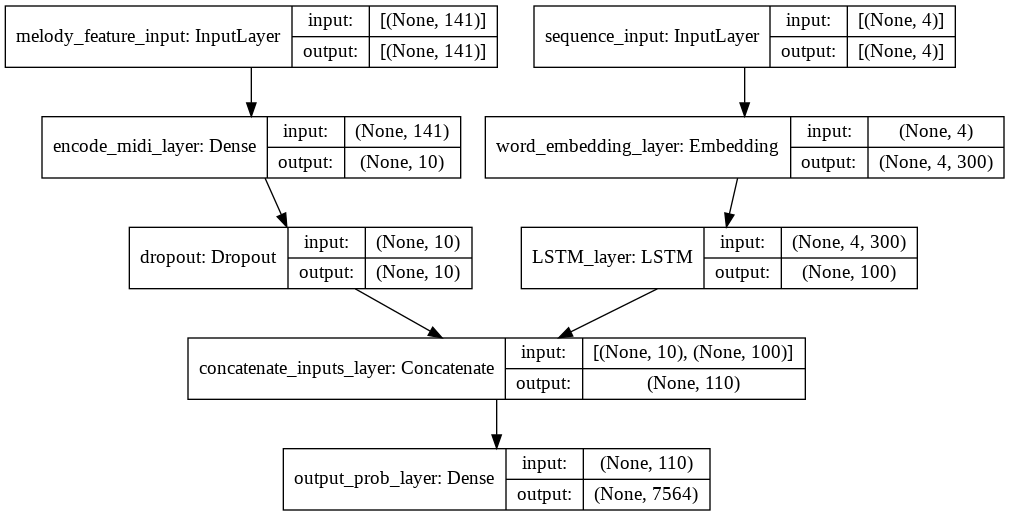

In [37]:
simple_model.plot()

### train

In [38]:
history = simple_model.fit(simple_train_gen,simple_val_gen,train_parameters)
simple_model.model.save(simple_model_path)

1773/1773 [==============================] - 261s 146ms/step - loss: 6.0165 - accuracy: 0.1378 - val_loss: 5.4720 - val_accuracy: 0.1836


INFO:tensorflow:Assets written to: simple_model/assets


INFO:tensorflow:Assets written to: simple_model/assets


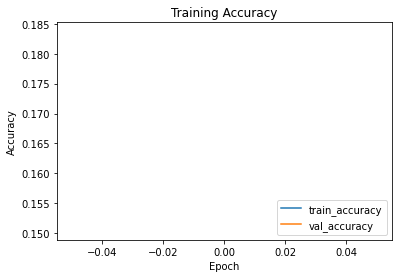

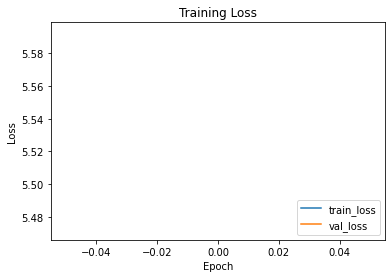

In [39]:
show_fit_history(history)

## Approch 2
use samples of melody as a sequence. apply RNN on both words and melody, learn the melody features as a sequence of sample notes
and then concat the encoded information to the word RNN reult to mix information from languege model and midi types.

### build

In [40]:
def get_model_complex(voc_index,midi_dim, word2vec_weights):
    """
    Build the Complex RNN ML Model
    apply RNN on words and melody and calculate attention on melody and concat 
    it to the result of the word RNN

    :param voc_index: word_index dict (word -> index)
    :param midi_dim: melody features shape
    :param word2vec_weights: embedding weights generate from word2vec
    :return: keras model with the complex arcitecture
    """
    drop_prob = 0.2
    voc_size = len(voc_index) + 1

    LSTM_UNIT_SIZE = 100
    ATTENTION_HEADS = 200
    DENSE_SIZE = 1024
    ENCODE_MIDI_DIM = 10
    dense_act = 'relu'

    K.clear_session()
    # midi input
    midi_input = Input(shape=midi_dim, name="melody_encoder_input")
    stm = LSTM(LSTM_UNIT_SIZE)(midi_input)
    encode_midi_layer = Dense(ENCODE_MIDI_DIM, activation=dense_act,name="encode_midi_layer")(stm)
    drop_out_layer = Dropout(0.8)(encode_midi_layer)
    
    # word sequence input
    seq_input = Input(shape=(MAX_SEQUENCE_LENGTH-1,), name="sequence_decoder_input")
    seq_embed = Embedding(voc_size,EMBEDDING_DIM,weights=[word2vec_weights],input_length=MAX_SEQUENCE_LENGTH-1,trainable=False,name='word_embedding_layer')(seq_input)
    seq_lstm = LSTM(units=LSTM_UNIT_SIZE,name="LSTM_seq_layer")(seq_embed)

    concat_layer = concatenate([drop_out_layer, seq_lstm],name="concat_layer")

    out_layer = Dense(voc_size,activation='softmax',name="output_prob_layer")(concat_layer)

    model = Model([seq_input,midi_input], out_layer)
  
    return model

In [41]:
# complex_model.model = keras.models.load_model(complex_model_path)
complex_model = LyricsMidiGenerator(word_index,emb_weights,train_midi_complex_shape,get_model_complex,"complex model")

In [42]:
complex_train_gen = BatchGenerator(train_folder_path,"complex",train_list_IDs,train_list_labels,train_song_index,train_midi_complex_shape)
complex_val_gen = BatchGenerator(test_folder_path,"complex",test_list_IDs,test_list_labels,test_song_index,test_midi_complex_shape)

complex_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
melody_encoder_input (InputLaye [(None, 200, 140)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 100)          96400       melody_encoder_input[0][0]       
__________________________________________________________________________________________________
sequence_decoder_input (InputLa [(None, 4)]          0                                            
__________________________________________________________________________________________________
encode_midi_layer (Dense)       (None, 10)           1010        lstm[0][0]                       
______________________________________________________________________________________________

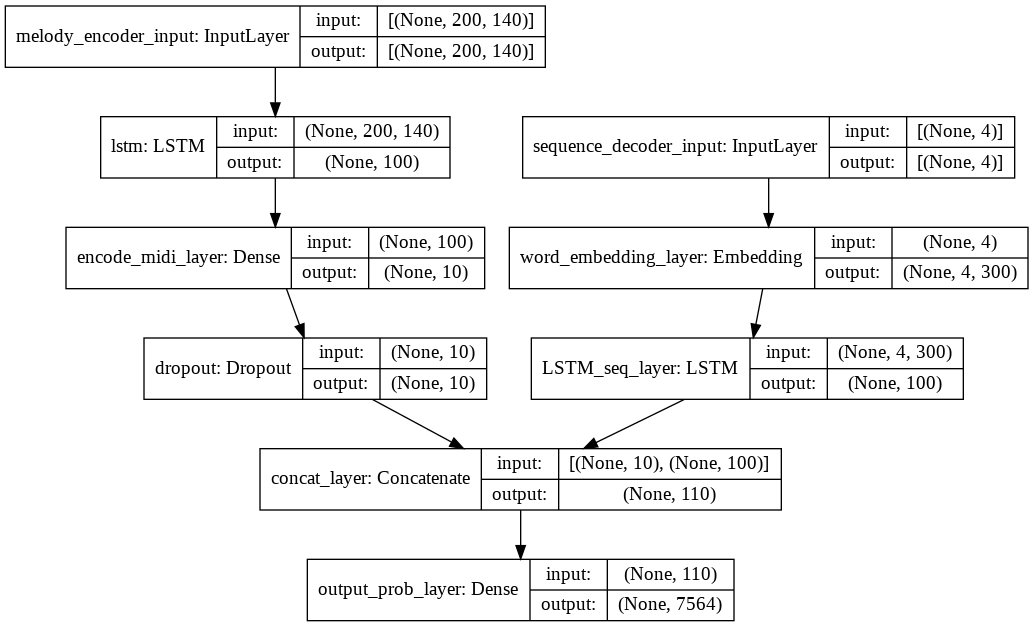

In [43]:
complex_model.plot()

### train

In [44]:
complex_model.model.save(os.path.join("drive2","MyDrive","deep_ass3","final_final",complex_model_path))

INFO:tensorflow:Assets written to: drive2/MyDrive/deep_ass3/final_final/complex_model/assets


INFO:tensorflow:Assets written to: drive2/MyDrive/deep_ass3/final_final/complex_model/assets


In [45]:
history = complex_model.fit(complex_train_gen,complex_val_gen,train_parameters)
complex_model.model.save(os.path.join("drive","MyDrive","deep_ass3","final_v3",complex_model_path))

1773/1773 [==============================] - 2776s 2s/step - loss: 5.6156 - accuracy: 0.1522 - val_loss: 5.3171 - val_accuracy: 0.1898


INFO:tensorflow:Assets written to: drive/MyDrive/deep_ass3/final_v3/complex_model/assets


INFO:tensorflow:Assets written to: drive/MyDrive/deep_ass3/final_v3/complex_model/assets


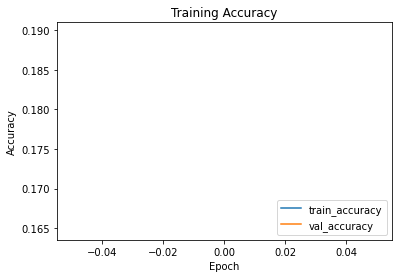

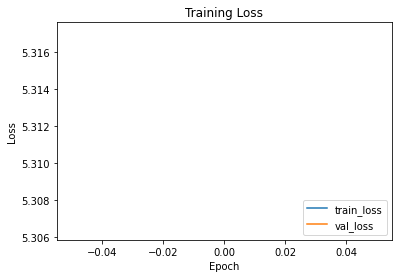

In [46]:
show_fit_history(history)

# **Test, Analyze and Compare**

## Analyze

In [47]:
def create_lyrics_for_model(model,type_folder_s_name,word_seed_list,test_set,scale):
  """
  Generate lyrics with a given model and data set, use the first word of the
  original and a given word_seed_list for each melody
  
  :param model: model that can generate lyrics
  :param type_folder_s_name: type of midi features to use
  :param word_seed_list: list with tokens to use as a seed to generate lyrics
  :param test_set: data set with melody and lyrics to generate from
  :return: list of generated lyrics of form [[lyrics_original_seed,lyrics_seed1,lyrics_seed2,...]]
  """
  generated_lyrics = []

  for song_id, row in enumerate(test_set):

    generated = []
    midi_info = np.load(os.path.join(test_folder_path,type_folder_s_name,midi_f_start_name) + str(song_id) + '.npy')

    original_seed = model.index_word[row[TOKENS][0]]
    
    seed_list = [original_seed]
    seed_list.extend(word_seed_list)
    
    for seed in seed_list:
      gen_lyrics = model.generate_song(seed,midi_info,limit=len(row[TOKENS]),random_scale=scale)
      generated.append(gen_lyrics)

    generated_lyrics.append(generated)

  return generated_lyrics

In [48]:
word_seed_list = ["fear","love","sad"]
random_scale = 20

ts_s_generate = time.time()

In [49]:
simple_generated_lyrics =  create_lyrics_for_model(simple_model,"simple",word_seed_list,test_set,random_scale)

ts_c_generate = time.time()
print("Done Generating {} Lyrics with simple model, {} sec elapsed".format(len(simple_generated_lyrics) * (len(word_seed_list) + 1),round(ts_c_generate- ts_s_generate,3)))

Done Generating 20 Lyrics with simple model, 42.569 sec elapsed


In [50]:
complex_generated_lyrics =   create_lyrics_for_model(complex_model,"complex",word_seed_list,test_set,random_scale)

print("Done Generating {} Lyrics with complex model, {} sec elapsed".format(len(complex_generated_lyrics) * (len(word_seed_list) + 1),round(time.time()- ts_c_generate,3)))

Done Generating 20 Lyrics with complex model, 55.855 sec elapsed


## Compare

In [81]:
index_word = {}
simple_lyrics = []
complex_lyrics = []
for word, index in word_index.items():
  index_word[index] = word

for song_id, row in enumerate(test_set):
  print("=" * 15)
  print()
  print("Generating Lyrics for '{}' by '{}'".format(row[SONG_NAME],row[AUTHOR]))
  print()
  for i in range(len(word_seed_list) + 1): # for original
    print("-" * 10)
    if i == 0: # Original seed
      print("Original Lyric Seed: {}".format(index_word[row[TOKENS][0]]))
    else:
      print("Seed: {}".format(word_seed_list[i-1]))
    print()

    simple_tokens = simple_generated_lyrics[song_id][i]
    complex_tokens = complex_generated_lyrics[song_id][i]

    print(">> Simple Model Lyrics:")
    simple_text_lyrics = " ".join(simple_tokens)
    simple_text_lyrics = simple_text_lyrics.replace(SENTENCE_DELIMITER + " " + SENTENCE_DELIMITER,SENTENCE_DELIMITER)
    simple_text_lyrics = simple_text_lyrics.replace(" " + SENTENCE_DELIMITER,"\n")
    simple_text_lyrics = simple_text_lyrics.replace(" " + LYRICS_END,"\n")
    simple_lyrics.append(simple_text_lyrics)
    print(simple_text_lyrics)
    print()
    print(">> Complex Model Lyrics:")
    complex_text_lyrics = " ".join(complex_tokens)
    complex_text_lyrics = complex_text_lyrics.replace(SENTENCE_DELIMITER + " " + SENTENCE_DELIMITER,SENTENCE_DELIMITER)
    complex_text_lyrics = complex_text_lyrics.replace(" " + SENTENCE_DELIMITER,"\n")
    complex_text_lyrics = complex_text_lyrics.replace(" " + LYRICS_END,"\n")
    complex_lyrics.append(complex_text_lyrics)
    print(complex_text_lyrics)
    print("-" * 10)
  print()
  print("=" * 15)


Generating Lyrics for 'eternal flame' by 'the bangles'

----------
Original Lyric Seed: close

>> Simple Model Lyrics:
close
 im dont get a little
 i just so
 i got a song
 im gonna
 you got to make me
 when if you want be you go to see



>> Complex Model Lyrics:
close
 cause the morning
 i cant want a man is it in an the day
 that i could you have to do
 i was the one day
 and its a time
 and you can to be all
 you will know its time
 and the way i feel my world of the time
 its gonna to be this world
 i do you want
 its the time


----------
----------
Seed: fear

>> Simple Model Lyrics:
fear to the life
 and i know you feel
 but a chance of the
 in the same man for the a man
 i can go on me that it and a man that



>> Complex Model Lyrics:
fear
 but you feel i want you be right
 and we will the all
 and they dont you want
 and youre so in the end you cant


----------
----------
Seed: love

>> Simple Model Lyrics:
love
 and tell me the love to have
 you know you want to be



>> 

In [52]:
!pip install afinn

In [82]:
from afinn import Afinn
afinn = Afinn()

# get the sentiment score for each seed word
word_scores = []
for word in word_seed_list:
  score = afinn.score(word)
  word_scores.append(score)
  print('word: ' + word + ', ' + 'score: ' + str(score))
# word_scores

word: fear, score: -2.0
word: love, score: 3.0
word: sad, score: -2.0


analysis the output by sentiment analysis:

In [83]:
# check sentiment for the simple model output
sad_score = 0
love_score = 0
fear_score = 0
for output in simple_lyrics:
  if output.split(' ')[0] == 'sad':
    sad_score += afinn.score(output)
  elif output.split(' ')[0] == 'love':
    love_score += afinn.score(output)
  elif output.split(' ')[0] == 'fear':
    fear_score += afinn.score(output)
print('sad sentiment score: ' + str(sad_score / 5))
print('love sentiment score: ' + str(love_score / 5))
print('fear sentiment score: ' + str(fear_score / 5))

sad sentiment score: 0.8
love sentiment score: 2.0
fear sentiment score: 1.2


In [84]:
sentiment_df = pd.DataFrame(columns=['fear', 'love', 'sad'])
sad_score = 0
love_score = 0
fear_score = 0
for output in simple_lyrics:
  if output.split(' ')[0] == 'fear':
    sad_score += afinn.score(output)
  elif output.split(' ')[0] == 'love':
    love_score += afinn.score(output)
  elif output.split(' ')[0] == 'sad':
    fear_score += afinn.score(output)

In [85]:
# check sentiment for the complex model output
sad_score = 0
love_score = 0
fear_score = 0
for output in complex_lyrics:
  if output.split(' ')[0] == 'sad':
    sad_score += afinn.score(output)
  elif output.split(' ')[0] == 'love':
    love_score += afinn.score(output)
  elif output.split(' ')[0] == 'fear':
    fear_score += afinn.score(output)
print('sad sentiment score: ' + str(sad_score / 5))
print('love sentiment score: ' + str(love_score / 5))
print('fear sentiment score: ' + str(fear_score / 5))

sad sentiment score: 0.0
love sentiment score: 6.2
fear sentiment score: 0.4


analysis the output by cosine similarity:

In [56]:
# measure the similarity between two sentences using cosine similarity.
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [57]:
def calculate_cosine_similarity(s1, s2):
  # tokenization
  X_list = word_tokenize(s1) 
  Y_list = word_tokenize(s2)

  # sw contains the list of stopwords
  sw = stopwords.words('english') 
  l1 =[];l2 =[]

  # remove stop words from the string
  X_set = {w for w in X_list if not w in sw} 
  Y_set = {w for w in Y_list if not w in sw}

  # form a set containing keywords of both strings 
  rvector = X_set.union(Y_set) 
  for w in rvector:
      if w in X_set: l1.append(1) # create a vector
      else: l1.append(0)
      if w in Y_set: l2.append(1)
      else: l2.append(0)
  c = 0

  # cosine formula 
  for i in range(len(rvector)):
          c+= l1[i]*l2[i]
  cosine = c / float((sum(l1)*sum(l2))**0.5)
  return cosine

In [58]:
import pandas as pd

In [80]:
songs_names = [test_set[0][1], test_set[1][1], test_set[2][1], test_set[3][1], test_set[4][1]]
similarity_df = pd.DataFrame(index=songs_names, columns=['original', 'fear', 'love', 'sad'])
for i in range(5): # there are 5 songs in the test set
  row = []
  for j in range(4): # there are 4 outputs for each song
    sim = calculate_cosine_similarity(test_set[i][2], simple_lyrics[i*j + j])
    row.append(sim)
  similarity_df.loc[test_set[i][1]] = row
similarity_df

,original,fear,love,sad
eternal flame,0.140642,0.127775,0.0845154,0
honesty,0.103203,0.248069,0.124035,0.198898
lovefool,0.111187,0,0.25,0.133631
barbie girl,0.131662,0,0.118678,0.265372
all the small things,0.121367,0.103142,0.119098,0.0439799


In [79]:
songs_names = [test_set[0][1], test_set[1][1], test_set[2][1], test_set[3][1], test_set[4][1]]
similarity_df = pd.DataFrame(index=songs_names, columns=['original', 'fear', 'love', 'sad'])
for i in range(5): # there are 5 songs in the test set
  row = []
  for j in range(4): # there are 4 outputs for each song
    sim = calculate_cosine_similarity(test_set[i][2], complex_lyrics[i*j + j])
    row.append(sim)
  similarity_df.loc[test_set[i][1]] = row
similarity_df

,original,fear,love,sad
eternal flame,0.126773,0.179284,0.0597614,0.0534522
honesty,0.124035,0.131559,0.214834,0.124035
lovefool,0.167038,0.126773,0.178174,0.202031
barbie girl,0.0890086,0.102778,0.197492,0.159223
all the small things,0.109399,0,0.145865,0.150094


In [61]:
songs_score = []
for output in simple_lyrics:
  if output.split(' ')[0] == 'sad':
    sad_score += afinn.score(output)
  elif output.split(' ')[0] == 'love':
    love_score += afinn.score(output)
  elif output.split(' ')[0] == 'fear':
    fear_score += afinn.score(output)
print('sad score: ' + str(sad_score))
print('love score: ' + str(love_score))
print('fear score: ' + str(fear_score))

sad score: 4.0
love score: 41.0
fear score: 8.0
